# Dataset Split: Multiple Balanced Ratios with Video Integrity

This notebook creates **multiple balanced dataset splits** with different background-to-target ratios while ensuring:
- **Video-level grouping**: All frames from the same video stay together
- **Ratio control**: Generate splits at 95-5, 90-10, 80-20, ..., 0-100 (background-target)
- **Reduction strategy**: When reducing background images, keep at least 1 per video first, then randomly remove videos
- **Upsampling dataset**: Create augmented versions where target classes are upsampled to balance with background
- **Comprehensive output**: Export splits as text files and generate visualizations and statistics

**Ratios to create:**
- 100-0 (original, all background)
- 95-5, 90-10, 80-20, 70-30, 60-40, 50-50, 40-60, 30-70, 20-80, 10-90, 5-95
- 0-100 (only targets)

In [35]:
# Import Required Libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import json

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print('✓ Libraries imported')

✓ Libraries imported


## Configuration and Paths

In [36]:
# Base project directory
BASE_DIR = Path(r'/home/detect/DeTect_TaiwanBirds_VideoDetector')

# Input dataset CSV file
DATASET_CSV_PATH = BASE_DIR / 'dataset' / 'csvs' / 'annotations.csv'

# Output directory for split files
SPLITS_OUTPUT_DIR = BASE_DIR / 'dataset' / 'csvs' / 'split_ratios'
SPLITS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratio configurations (background_ratio - target_ratio)
RATIO_CONFIGS = [
    (95, 5),
    (90, 10),
    (80, 20),
    (70, 30),
    (60, 40),
    (50, 50),
    (40, 60),
    (30, 70),
    (20, 80),
    (10, 90),
    (5, 95),
    (0, 100),   # only targets
]

# Random seed
RANDOM_SEED = 42

print(f'Base directory: {BASE_DIR}')
print(f'Dataset CSV: {DATASET_CSV_PATH}')
print(f'Splits output dir: {SPLITS_OUTPUT_DIR}')
print(f'Ratio configs: {len(RATIO_CONFIGS)} splits to create')

Base directory: /home/detect/DeTect_TaiwanBirds_VideoDetector
Dataset CSV: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/annotations.csv
Splits output dir: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios
Ratio configs: 12 splits to create


## Load and Parse Original Dataset

In [37]:
# Load dataset from CSV
if not DATASET_CSV_PATH.exists():
    raise FileNotFoundError(f'Dataset CSV not found: {DATASET_CSV_PATH}')

df_images = pd.read_csv(DATASET_CSV_PATH)
print(f'✓ Loaded dataset from CSV')
print(f'DataFrame shape: {df_images.shape}')

print(f'\nDataset statistics:')
print(f'  Total images: {len(df_images)}')
print(f'  Unique videos: {df_images["video_name"].nunique()}')
if 'num_targets' in df_images.columns:
    print(f'  Total targets: {df_images["num_targets"].sum()}')

# Display first few rows
print(f'\nFirst rows of dataset:')
df_images.head()

✓ Loaded dataset from CSV
DataFrame shape: (21614, 10)

Dataset statistics:
  Total images: 21614
  Unique videos: 2007
  Total targets: 1965

First rows of dataset:


,image_path,image_width,image_height,image_format,num_targets,classes,has_annotations,video_path,video_name,frame_number
0,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,0
1,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,124
2,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,149
3,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,16
4,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,174


In [38]:
# Group images by video to maintain video integrity
videos_dict = defaultdict(list)
for _, row in df_images.iterrows():
    video_name = row['video_name']
    videos_dict[video_name].append({
        'image_path': row['image_path'],
        'num_targets': row['num_targets'],
        'frame_number': row.get('frame_number', -1)
    })

# Create video-level dataframe
video_rows = []
for video_name, frames in videos_dict.items():
    total_targets = sum(f['num_targets'] for f in frames)
    num_frames = len(frames)
    has_targets = 'target' if total_targets > 0 else 'background'
    
    video_rows.append({
        'video_name': video_name,
        'num_frames': num_frames,
        'total_targets': total_targets,
        'video_category': has_targets,
        'frames': frames
    })

df_videos = pd.DataFrame(video_rows)
print(f'✓ Grouped into {len(df_videos)} unique videos')
print(f'\nVideo-level statistics:')
print(f'  Total frames: {len(df_images)}')
print(f'  Avg frames per video: {len(df_images) / len(df_videos):.1f}')
print(f'  Min/Max frames: {df_videos["num_frames"].min()}/{df_videos["num_frames"].max()}')
print(f'  Total targets: {df_videos["total_targets"].sum()}')

# Analyze video categories
category_counts = df_videos['video_category'].value_counts()
print(f'\nVideo Category Distribution:')
for cat in ['background', 'target']:
    if cat in category_counts.index:
        count = category_counts[cat]
        pct = count / len(df_videos) * 100
        print(f'  {cat:15s}: {count:3d} videos ({pct:5.1f}%)')

✓ Grouped into 2007 unique videos

Video-level statistics:
  Total frames: 21614
  Avg frames per video: 10.8
  Min/Max frames: 10/64
  Total targets: 1965

Video Category Distribution:
  background     : 1777 videos ( 88.5%)
  target         : 230 videos ( 11.5%)


## Analyze Original Dataset Balance

In [39]:
# Calculate original dataset balance
def calculate_dataset_balance(df_vids):
    """Calculate background vs target image distribution."""
    bg_images = []
    target_images = []
    
    for _, row in df_vids.iterrows():
        for frame in row['frames']:
            if frame['num_targets'] == 0:
                bg_images.append(frame['image_path'])
            else:
                target_images.append(frame['image_path'])
    
    return bg_images, target_images

bg_original, tg_original = calculate_dataset_balance(df_videos)

print(f'Original Dataset Balance:')
bg_images_percentage = len(bg_original)/(len(bg_original)+len(tg_original))*100
tg_images_percentage = len(tg_original)/(len(bg_original)+len(tg_original))*100
print(f'  Background images: {len(bg_original)} ({bg_images_percentage:.1f}%)')
print(f'  Target images:     {len(tg_original)} ({tg_images_percentage:.1f}%)')
# Add original ratio
RATIO_CONFIGS = RATIO_CONFIGS + [(bg_images_percentage, tg_images_percentage)]
print(f'  Total images:      {len(bg_original) + len(tg_original)}')

# Analyze target classes distribution
target_classes = []
for _, row in df_videos.iterrows():
    for frame in row['frames']:
        if frame['num_targets'] > 0:
            target_classes.extend([frame['num_targets']] * frame['num_targets'])

print(f'\nTarget detection statistics:')
print(f'  Total targets detected: {len(target_classes)}')

# Calculate stats for each video
print(f'\nPer-video statistics:')
print(f'  Videos with targets: {(df_videos["total_targets"] > 0).sum()}')
print(f'  Avg targets per target-video: {df_videos[df_videos["total_targets"] > 0]["total_targets"].mean():.2f}')
print(f'  Max targets in one video: {df_videos["total_targets"].max()}')

Original Dataset Balance:
  Background images: 19977 (92.4%)
  Target images:     1637 (7.6%)
  Total images:      21614

Target detection statistics:
  Total targets detected: 1965

Per-video statistics:
  Videos with targets: 230
  Avg targets per target-video: 8.54
  Max targets in one video: 57


## Extract Class Information from Labels

In [40]:
df_images

,image_path,image_width,image_height,image_format,num_targets,classes,has_annotations,video_path,video_name,frame_number
0,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,0
1,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,124
2,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,149
3,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,16
4,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,174
...,...,...,...,...,...,...,...,...,...,...
21609,/home/data/F2/videos/2025-05-14/images/A03_add...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_add...,A03_add11432-8a49-3274-90fe-f88499298c8a,224
21610,/home/data/F2/videos/2025-05-14/images/A03_add...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_add...,A03_add11432-8a49-3274-90fe-f88499298c8a,24
21611,/home/data/F2/videos/2025-05-14/images/A03_add...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_add...,A03_add11432-8a49-3274-90fe-f88499298c8a,49
21612,/home/data/F2/videos/2025-05-14/images/A03_add...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_add...,A03_add11432-8a49-3274-90fe-f88499298c8a,74


In [41]:
# Class ID mapping (update based on your dataset)
CLASS_ID_TO_NAME = {
    0: "Bat",
    1: "Bird",
    2: "Insect",
    3: "Drone",
    4: "Plane",
    5: "Other",
    6: "Unknown",
}

# Extract class information for all images
print('Extracting class information from label files...')
image_class_info = {}

for idx, row in df_images.iterrows():
    img_path = row['image_path']
    classes = row["classes"].split(';')
    num_targets = row["num_targets"]
    has_targets = row["has_annotations"]
    
    image_class_info[img_path] = {
        'classes': classes,
        'num_targets': num_targets,
        'has_target': has_targets
    }

print(f'✓ Extracted class info for {len(image_class_info)} images')
print(f'\nClass Distribution (total detections):')
for cls_name in sorted(CLASS_ID_TO_NAME.values()):
    # count number of targets per class (num_targets)
    count = sum(info['num_targets'] for info in image_class_info.values() if cls_name in info['classes'])
    cls_id = [k for k, v in CLASS_ID_TO_NAME.items() if v == cls_name][0]
    print(f'  {cls_name:15s} (ID {cls_id}): {count:5d} detections')


# Count images per class (not detections)
images_per_class = defaultdict(int)
for info in image_class_info.values():
    for cls in set(info['classes']):  # Use set to count each image once per class
        images_per_class[cls] += 1

print(f'\nImages per Class (unique images):')
for cls_id in sorted(images_per_class.keys()):
    cls_name = CLASS_ID_TO_NAME.get(cls_id, f"{cls_id}")
    count = images_per_class[cls_id]
    print(f'  {cls_name:15s} (ID {cls_id}): {count:5d} images')

Extracting class information from label files...


✓ Extracted class info for 21614 images

Class Distribution (total detections):
  Bat             (ID 0):    46 detections
  Bird            (ID 1):   477 detections
  Drone           (ID 3):     0 detections
  Insect          (ID 2):    71 detections
  Other           (ID 5):    39 detections
  Plane           (ID 4):   537 detections
  Unknown         (ID 6):   810 detections

Images per Class (unique images):
  Background      (ID Background): 19977 images
  Bat             (ID Bat):    46 images
  Bird            (ID Bird):   424 images
  Insect          (ID Insect):    69 images
  Other           (ID Other):    15 images
  Plane           (ID Plane):   352 images
  Unknown         (ID Unknown):   736 images


# Train-Val-Test Split with Class Coverage Guarantee

This section performs:
1. **Video-aware train-val-test split** with intelligent video allocation per class
2. **Class coverage guarantee** - ensures ALL classes appear in both train and validation
3. **Image-based proportions** - maintains 70-15-15 ratio based on image count (not video count)
4. **Smart allocation strategy**: 1 video→train, 2 videos→train+val, 3+→distributed 70-15-15


In [42]:
def create_train_val_test_split(df_videos, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Create train-val-test split ensuring:
    1. Video integrity (all frames from same video go to same split)
    2. Class representation (ALL classes appear in train and validation)
    3. Image-based proportions (ratios calculated on images, not videos)
    4. Allocation: 1 video→train, 2 videos→train+val, 3+→train+val+test
    
    Parameters:
    - df_videos: DataFrame with video information
    - train_ratio: target proportion for training (default 0.70)
    - val_ratio: target proportion for validation (default 0.15)
    - test_ratio: target proportion for test (default 0.15)
    - seed: random seed for reproducibility
    
    Returns:
    - Dictionary with 'train', 'val', 'test' keys containing lists of image paths and video lists
    """
    rng = np.random.default_rng(seed)
    
    # Helper function: Get dominant class for each target video
    def get_video_dominant_class(video_row):
        """Get the dominant class in a video (most frequent class)"""
        class_counts = Counter()
        for frame in video_row['frames']:
            img_path = frame['image_path']
            img_info = image_class_info.get(img_path, {'classes': []})
            for cls in img_info['classes']:
                class_counts[cls] += 1
        
        if class_counts:
            return class_counts.most_common(1)[0][0]
        return None
    
    # Separate videos into background and target
    bg_videos = df_videos[df_videos['video_category'] == 'background'].copy()
    tg_videos = df_videos[df_videos['video_category'] == 'target'].copy()
    
    # Add dominant class for target videos
    tg_videos = tg_videos.copy()
    tg_videos['dominant_class'] = tg_videos.apply(get_video_dominant_class, axis=1)
    
    print(f'Video Distribution:')
    print(f'  Background videos: {len(bg_videos)}')
    print(f'  Target videos: {len(tg_videos)}')
    
    # Analyze target videos by dominant class
    print(f'\nTarget videos by dominant class:')
    class_distribution = tg_videos['dominant_class'].value_counts()
    for cls, count in class_distribution.items():
        cls_name = CLASS_ID_TO_NAME.get(cls, f'Class_{cls}')
        print(f'  {cls_name:15s}: {count:3d} videos')
    
    # ============= VIDEO ALLOCATION PER CLASS =============
    train_tg_videos = []
    val_tg_videos = []
    test_tg_videos = []
    
    for class_id in sorted([c for c in class_distribution.index if not pd.isna(c)]):
        cls_name = CLASS_ID_TO_NAME.get(class_id, f'Class_{class_id}')
        
        class_videos = tg_videos[tg_videos['dominant_class'] == class_id].copy()
        class_videos = class_videos.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        num_videos = len(class_videos)
        
        # Helper: count images in videos
        def count_images_in_videos(video_list):
            count = 0
            for _, row in video_list.iterrows():
                count += len(row['frames'])
            return count
        
        if num_videos == 1:
            # Only 1 video → goes to train
            train_tg_videos.extend(list(class_videos['video_name']))
            print(f'  {cls_name:15s} ({num_videos:2d} videos): Train only')
            
        elif num_videos == 2:
            # 2 videos → 1 to train, 1 to val
            train_tg_videos.extend(list(class_videos.iloc[:1]['video_name']))
            val_tg_videos.extend(list(class_videos.iloc[1:]['video_name']))
            train_imgs = count_images_in_videos(class_videos.iloc[:1])
            val_imgs = count_images_in_videos(class_videos.iloc[1:])
            print(f'  {cls_name:15s} ({num_videos:2d} videos): Train ({train_imgs} imgs) | Val ({val_imgs} imgs)')
            
        else:
            # 3+ videos → distribute by 70-15-15 ratio (by images to ensure proportions)
            # Calculate how many images per split based on image count
            total_images = count_images_in_videos(class_videos)
            
            # Distribute videos to get ~70-15-15 by images
            train_images_target = int(total_images * train_ratio)
            val_images_target = int(total_images * val_ratio)
            
            current_train_images = 0
            current_val_images = 0
            
            for idx, (_, video_row) in enumerate(class_videos.iterrows()):
                num_frames = len(video_row['frames'])
                
                # Assign to split that needs more images
                if current_train_images < train_images_target:
                    train_tg_videos.append(video_row['video_name'])
                    current_train_images += num_frames
                elif current_val_images < val_images_target:
                    val_tg_videos.append(video_row['video_name'])
                    current_val_images += num_frames
                else:
                    test_tg_videos.append(video_row['video_name'])
            
            print(f'  {cls_name:15s} ({num_videos:2d} videos): ' +
                  f'Train ({current_train_images} imgs) | Val ({current_val_images} imgs) | ' +
                  f'Test ({total_images - current_train_images - current_val_images} imgs)')
    
    # ============= ALLOCATE BACKGROUND VIDEOS =============
    print(f'\nBackground video allocation (randomly distributed):')
    
    # Shuffle and allocate background videos
    bg_videos = bg_videos.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Count total images in BG videos
    def count_images_in_bg_videos(video_list):
        total = 0
        for _, row in video_list.iterrows():
            total += len(row['frames'])
        return total
    
    total_bg_images = count_images_in_bg_videos(bg_videos)
    train_bg_target = int(total_bg_images * train_ratio)
    val_bg_target = int(total_bg_images * val_ratio)
    
    current_train_bg = 0
    current_val_bg = 0
    train_bg_videos = []
    val_bg_videos = []
    test_bg_videos = []
    
    for _, video_row in bg_videos.iterrows():
        num_frames = len(video_row['frames'])
        
        if current_train_bg < train_bg_target:
            train_bg_videos.append(video_row['video_name'])
            current_train_bg += num_frames
        elif current_val_bg < val_bg_target:
            val_bg_videos.append(video_row['video_name'])
            current_val_bg += num_frames
        else:
            test_bg_videos.append(video_row['video_name'])
    
    print(f'  BG videos: Train ({current_train_bg} imgs) | Val ({current_val_bg} imgs) | ' +
          f'Test ({total_bg_images - current_train_bg - current_val_bg} imgs)')
    
    # ============= COMBINE AND EXTRACT IMAGES =============
    train_videos = train_bg_videos + train_tg_videos
    val_videos = val_bg_videos + val_tg_videos
    test_videos = test_bg_videos + test_tg_videos
    
    # Extract images from videos
    def extract_images_from_videos(video_names, df_vids):
        """Extract all images from a list of video names"""
        images = []
        for video_name in video_names:
            video_row = df_vids[df_vids['video_name'] == video_name]
            if len(video_row) > 0:
                frames = video_row.iloc[0]['frames']
                for frame in frames:
                    images.append(frame['image_path'])
        return images
    
    train_images = extract_images_from_videos(train_videos, df_videos)
    val_images = extract_images_from_videos(val_videos, df_videos)
    test_images = extract_images_from_videos(test_videos, df_videos)
    
    # Calculate proportions
    train_bg = len([x for x in train_images if x in bg_original])
    train_tg = len([x for x in train_images if x in tg_original])
    val_bg = len([x for x in val_images if x in bg_original])
    val_tg = len([x for x in val_images if x in tg_original])
    test_bg = len([x for x in test_images if x in bg_original])
    test_tg = len([x for x in test_images if x in tg_original])
    
    # Report final distribution
    print(f'\n{"="*100}')
    print(f'Final image distribution (image-based proportions):')
    print(f'{"="*100}')
    print(f'  Train: {train_bg:5d} BG + {train_tg:5d} TG = {len(train_images):6d} images '
          f'({train_bg/(train_bg+train_tg)*100:5.1f}% BG / {train_tg/(train_bg+train_tg)*100:5.1f}% TG)')
    print(f'  Val:   {val_bg:5d} BG + {val_tg:5d} TG = {len(val_images):6d} images '
          f'({val_bg/(val_bg+val_tg)*100:5.1f}% BG / {val_tg/(val_bg+val_tg)*100:5.1f}% TG)')
    print(f'  Test:  {test_bg:5d} BG + {test_tg:5d} TG = {len(test_images):6d} images '
          f'({test_bg/(test_bg+test_tg)*100:5.1f}% BG / {test_tg/(test_bg+test_tg)*100:5.1f}% TG)')
    
    # Verify class coverage
    print(f'\nClass coverage verification:')
    print(f'  {"Class":<15} {"Train Videos":<15} {"Val Videos":<15} {"Test Videos":<15} {"Represented in Train?":<20} {"Represented in Val?":<20} {"Represented in Test?":<20}')
    print(f'  {"-"*75}')
    
    for class_id in sorted([c for c in class_distribution.index if not pd.isna(c)]):
        cls_name = CLASS_ID_TO_NAME.get(class_id, f'Class_{class_id}')
        
        train_count = sum(1 for v in train_tg_videos if v in tg_videos[tg_videos['dominant_class'] == class_id]['video_name'].values)
        val_count = sum(1 for v in val_tg_videos if v in tg_videos[tg_videos['dominant_class'] == class_id]['video_name'].values)
        test_count = sum(1 for v in test_tg_videos if v in tg_videos[tg_videos['dominant_class'] == class_id]['video_name'].values)
        
        train_repr = "✓ YES" if train_count > 0 else "✗ NO"
        val_repr = "✓ YES" if val_count > 0 else "✗ NO"
        test_repr = "✓ YES" if test_count > 0 else "✗ NO"
        
        print(f'  {cls_name:<15} {train_count:<15d} {val_count:<15d} {test_count:<15d} {train_repr:<20} {val_repr:<20} {test_repr:<20}')
    
    return {
        'train': {
            'images': train_images,
            'videos': train_videos,
            'num_bg': train_bg,
            'num_tg': train_tg,
            'total': len(train_images)
        },
        'val': {
            'images': val_images,
            'videos': val_videos,
            'num_bg': val_bg,
            'num_tg': val_tg,
            'total': len(val_images)
        },
        'test': {
            'images': test_images,
            'videos': test_videos,
            'num_bg': test_bg,
            'num_tg': test_tg,
            'total': len(test_images)
        }
    }

# Create the train-val-test split with class guarantee and image-based proportions
print('Creating train-val-test split with guaranteed class coverage and image-based proportions...\n')
tvt_split = create_train_val_test_split(df_videos, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=RANDOM_SEED)

Creating train-val-test split with guaranteed class coverage and image-based proportions...

Video Distribution:
  Background videos: 1777
  Target videos: 230

Target videos by dominant class:
  Class_Background: 131 videos
  Class_Unknown  :  38 videos
  Class_Plane    :  37 videos
  Class_Bird     :  20 videos
  Class_Other    :   2 videos
  Class_Bat      :   1 videos
  Class_Insect   :   1 videos
  Class_Background (131 videos): Train (1653 imgs) | Val (361 imgs) | Test (302 imgs)
  Class_Bat       ( 1 videos): Train only
  Class_Bird      (20 videos): Train (246 imgs) | Val (60 imgs) | Test (45 imgs)
  Class_Insect    ( 1 videos): Train only
  Class_Other     ( 2 videos): Train (10 imgs) | Val (10 imgs)
  Class_Plane     (37 videos): Train (288 imgs) | Val (70 imgs) | Test (50 imgs)
  Class_Unknown   (38 videos): Train (435 imgs) | Val (90 imgs) | Test (79 imgs)

Background video allocation (randomly distributed):
  BG videos: Train (12498 imgs) | Val (2680 imgs) | Test (2670 img

## Apply Ratio Balancing Strategies to Train and Val Sets


In [43]:
def apply_ratio_strategy(images_list, bg_ratio, tg_ratio, seed=42):
    """
    Apply ratio balancing strategy to a list of images while maintaining class distribution.
    
    Strategy:
    - All target images are kept (to maintain class balance)
    - Background images are sampled to achieve desired ratio
    - If ratio is inverted (more targets than BG desired), sample target images while maintaining class balance
    
    Parameters:
    - images_list: List of image paths to balance
    - bg_ratio: Desired background ratio (0-100)
    - tg_ratio: Desired target ratio (0-100)
    - seed: Random seed
    
    Returns:
    - Balanced list of image paths with class proportions maintained
    """
    rng = np.random.default_rng(seed)
    
    # Separate background and target images
    bg_images = [x for x in images_list if x in bg_original]
    tg_images = [x for x in images_list if x in tg_original]
    
    # Handle special cases
    if tg_ratio == 0:
        return bg_images
    elif bg_ratio == 0:
        return tg_images
    
    # Calculate desired numbers
    if len(tg_images) == 0:
        return bg_images
    
    # Group target images by class to maintain class balance
    tg_by_class = defaultdict(list)
    for img_path in tg_images:
        img_info = image_class_info.get(img_path, {'classes': []})
        # Group by first class
        if img_info['classes']:
            primary_class = img_info['classes'][0]
            tg_by_class[primary_class].append(img_path)
        else:
            tg_by_class['unknown'].append(img_path)
    
    # Use target images count as base for the ratio
    num_tg_desired = len(tg_images)
    num_bg_desired = int(num_tg_desired * (bg_ratio / tg_ratio)) if tg_ratio > 0 else 0
    
    # Sample background images to match desired ratio
    if len(bg_images) > num_bg_desired:
        # Sample without replacement if possible
        selected_bg_images = list(rng.choice(bg_images, size=num_bg_desired, replace=False))
    elif len(bg_images) < num_bg_desired:
        # Sample with replacement if we don't have enough
        selected_bg_images = list(rng.choice(bg_images, size=num_bg_desired, replace=True))
    else:
        selected_bg_images = bg_images.copy()
    
    # Keep all target images (preserves class distribution)
    selected_tg_images = tg_images.copy()
    
    # Combine and shuffle
    result = selected_bg_images + selected_tg_images
    rng.shuffle(result)
    
    return result

# Generate balanced versions of train and val sets with different ratios
print('Generating balanced train and validation splits...\n')

tvt_splits_data = {}

# Get base proportions from original train/val
train_bg_ratio = tvt_split['train']['num_bg'] / tvt_split['train']['total'] * 100
train_tg_ratio = tvt_split['train']['num_tg'] / tvt_split['train']['total'] * 100

print(f'Original Train Proportion: {train_bg_ratio:.1f}% BG / {train_tg_ratio:.1f}% TG')
print(f'Applying ratio strategies to train and val sets...\n')

# Define ratios to apply
ratio_configs_tvt = [
    (90, 10),
    (80, 20),
    (70, 30),
    (60, 40),
    (50, 50),
    (40, 60),
    (30, 70),
    (20, 80),
    (10, 90),
    (5, 95),
    (0, 100),    # Only targets
    (train_bg_ratio, train_tg_ratio),  # Original proportion
]

tvt_stats = []

for bg_ratio, tg_ratio in ratio_configs_tvt:
    ratio_key = f"{bg_ratio:.1f}-{tg_ratio:.1f}".replace('.0', '')
    
    # Apply strategy to both train and val
    train_balanced = apply_ratio_strategy(
        tvt_split['train']['images'], bg_ratio, tg_ratio, 
        seed=RANDOM_SEED
    )
    
    val_balanced = apply_ratio_strategy(
        tvt_split['val']['images'], bg_ratio, tg_ratio, 
        seed=RANDOM_SEED + 1
    )
    
    # Calculate actual statistics
    train_bg = len([x for x in train_balanced if x in bg_original])
    train_tg = len([x for x in train_balanced if x in tg_original])
    val_bg = len([x for x in val_balanced if x in bg_original])
    val_tg = len([x for x in val_balanced if x in tg_original])
    
    tvt_splits_data[f'train_{ratio_key}'] = {
        'images': train_balanced,
        'videos': tvt_split['train']['videos'],
        'num_bg': train_bg,
        'num_tg': train_tg,
        'total': len(train_balanced),
        'split_type': 'train'
    }
    
    tvt_splits_data[f'val_{ratio_key}'] = {
        'images': val_balanced,
        'videos': tvt_split['val']['videos'],
        'num_bg': val_bg,
        'num_tg': val_tg,
        'total': len(val_balanced),
        'split_type': 'val'
    }
    
    tvt_stats.append({
        'set': 'train',
        'ratio': ratio_key,
        'target_bg': bg_ratio,
        'target_tg': tg_ratio,
        'actual_bg': train_bg / len(train_balanced) * 100 if len(train_balanced) > 0 else 0,
        'actual_tg': train_tg / len(train_balanced) * 100 if len(train_balanced) > 0 else 0,
        'num_bg': train_bg,
        'num_tg': train_tg,
        'total': len(train_balanced)
    })
    
    tvt_stats.append({
        'set': 'val',
        'ratio': ratio_key,
        'target_bg': bg_ratio,
        'target_tg': tg_ratio,
        'actual_bg': val_bg / len(val_balanced) * 100 if len(val_balanced) > 0 else 0,
        'actual_tg': val_tg / len(val_balanced) * 100 if len(val_balanced) > 0 else 0,
        'num_bg': val_bg,
        'num_tg': val_tg,
        'total': len(val_balanced)
    })
    
    print(f'✓ {ratio_key:10s} | Train: {train_bg:5d}/{train_tg:5d} ({train_bg/len(train_balanced)*100:5.1f}% BG) | ' +
          f'Val: {val_bg:5d}/{val_tg:5d} ({val_bg/len(val_balanced)*100:5.1f}% BG)')

# Store test set
tvt_splits_data['test'] = tvt_split['test']

tvt_stats_df = pd.DataFrame(tvt_stats)
print(f'\n✓ All train-val balanced splits created successfully!')
print(f'Total configurations: {len(tvt_stats_df)} (train and val pairs)')


Generating balanced train and validation splits...

Original Train Proportion: 92.3% BG / 7.7% TG
Applying ratio strategies to train and val sets...



✓ 90-10      | Train: 10512/ 1168 ( 90.0% BG) | Val:  2259/  251 ( 90.0% BG)
✓ 80-20      | Train:  4672/ 1168 ( 80.0% BG) | Val:  1004/  251 ( 80.0% BG)
✓ 70-30      | Train:  2725/ 1168 ( 70.0% BG) | Val:   585/  251 ( 70.0% BG)
✓ 60-40      | Train:  1752/ 1168 ( 60.0% BG) | Val:   376/  251 ( 60.0% BG)
✓ 50-50      | Train:  1168/ 1168 ( 50.0% BG) | Val:   251/  251 ( 50.0% BG)
✓ 40-60      | Train:   778/ 1168 ( 40.0% BG) | Val:   167/  251 ( 40.0% BG)
✓ 30-70      | Train:   500/ 1168 ( 30.0% BG) | Val:   107/  251 ( 29.9% BG)
✓ 20-80      | Train:   292/ 1168 ( 20.0% BG) | Val:    62/  251 ( 19.8% BG)
✓ 10-90      | Train:   129/ 1168 (  9.9% BG) | Val:    27/  251 (  9.7% BG)
✓ 5-95       | Train:    61/ 1168 (  5.0% BG) | Val:    13/  251 (  4.9% BG)
✓ 0-100      | Train:     0/ 1168 (  0.0% BG) | Val:     0/  251 (  0.0% BG)
✓ 92.3-7.7   | Train: 14029/ 1168 ( 92.3% BG) | Val:  3014/  251 ( 92.3% BG)

✓ All train-val balanced splits created successfully!
Total configurations:

## Export Train-Val-Test Splits


In [47]:
# Create output directories for TVT splits (train/, val/, test/ under split_ratios)
SPLITS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

train_dir = SPLITS_OUTPUT_DIR / 'train'
val_dir = SPLITS_OUTPUT_DIR / 'val'
test_dir = SPLITS_OUTPUT_DIR / 'test'

train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

print('Exporting train-val-test splits...\n')
print(f'Output structure:')
print(f'  {train_dir}/')
print(f'  {val_dir}/')
print(f'  {test_dir}/\n')

for split_name, split_data in tvt_splits_data.items():
    if split_name == 'test':
        # Export test set
        txt_file = test_dir / 'test.txt'
        with open(txt_file, 'w') as f:
            for img_path in split_data['images']:
                f.write(f'{img_path}\n')
        
        stats_file = test_dir / 'test_stats.json'
        stats_info = {
            'split_name': 'test',
            'total_images': split_data['total'],
            'num_background': split_data['num_bg'],
            'num_target': split_data['num_tg'],
            'background_ratio': split_data['num_bg'] / split_data['total'] * 100 if split_data['total'] > 0 else 0,
            'target_ratio': split_data['num_tg'] / split_data['total'] * 100 if split_data['total'] > 0 else 0,
            'num_videos': len(split_data['videos'])
        }
        
        with open(stats_file, 'w') as f:
            json.dump(stats_info, f, indent=2)
        
        print(f'✓ test.txt')
        print(f'   Stats: {stats_info["total_images"]:5d} images | ' +
              f'BG: {stats_info["num_background"]:5d} ({stats_info["background_ratio"]:5.1f}%) | ' +
              f'TG: {stats_info["num_target"]:5d} ({stats_info["target_ratio"]:5.1f}%)')
    
    else:
        # Train and val splits with ratio labels (train_XX-YY.txt or val_XX-YY.txt)
        # Determine if it's train or val based on split_name
        split_type = split_data.get('split_type', 'unknown')
        
        if split_type == 'train':
            output_dir = train_dir
            file_prefix = 'train'
        elif split_type == 'val':
            output_dir = val_dir
            file_prefix = 'val'
        else:
            continue
        
        # Extract ratio from split_name (e.g., "train_95-5" -> "95-5")
        ratio_part = split_name.split('_', 1)[1]  # Get everything after "train_" or "val_"
        
        txt_file = output_dir / f'{file_prefix}_{ratio_part}.txt'
        with open(txt_file, 'w') as f:
            for img_path in split_data['images']:
                f.write(f'{img_path}\n')
        
        stats_file = output_dir / f'{file_prefix}_{ratio_part}_stats.json'
        stats_info = {
            'split_name': split_name,
            'split_type': split_type,
            'ratio': ratio_part,
            'total_images': split_data['total'],
            'num_background': split_data['num_bg'],
            'num_target': split_data['num_tg'],
            'background_ratio': split_data['num_bg'] / split_data['total'] * 100 if split_data['total'] > 0 else 0,
            'target_ratio': split_data['num_tg'] / split_data['total'] * 100 if split_data['total'] > 0 else 0,
            'num_videos': len(split_data['videos'])
        }
        
        with open(stats_file, 'w') as f:
            json.dump(stats_info, f, indent=2)
        
        print(f'✓ {file_prefix}_{ratio_part}.txt')

print(f'\n✓ All train-val-test splits exported to {SPLITS_OUTPUT_DIR}')
print(f'   Train splits: {train_dir}')
print(f'   Val splits:   {val_dir}')
print(f'   Test split:   {test_dir}')

# Display summary table
print('\n' + '='*100)
print('TRAIN-VAL-TEST SPLIT SUMMARY')
print('='*100)
tvt_stats_df


Exporting train-val-test splits...

Output structure:
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/train/
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/

✓ train_90-10.txt
✓ val_90-10.txt
✓ train_80-20.txt
✓ val_80-20.txt
✓ train_70-30.txt
✓ val_70-30.txt
✓ train_60-40.txt
✓ val_60-40.txt
✓ train_50-50.txt
✓ val_50-50.txt
✓ train_40-60.txt
✓ val_40-60.txt
✓ train_30-70.txt
✓ val_30-70.txt
✓ train_20-80.txt
✓ val_20-80.txt
✓ train_10-90.txt
✓ val_10-90.txt
✓ train_5-95.txt
✓ val_5-95.txt
✓ train_0-100.txt
✓ val_0-100.txt
✓ train_92.3-7.7.txt
✓ val_92.3-7.7.txt
✓ test.txt
   Stats:  3146 images | BG:  2928 ( 93.1%) | TG:   218 (  6.9%)

✓ All train-val-test splits exported to /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios
   Train splits: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/train
   Val sp

,set,ratio,target_bg,target_tg,actual_bg,actual_tg,num_bg,num_tg,total
0,train,90-10,90.000000,10.000000,90.000000,10.000000,10512,1168,11680
1,val,90-10,90.000000,10.000000,90.000000,10.000000,2259,251,2510
2,train,80-20,80.000000,20.000000,80.000000,20.000000,4672,1168,5840
3,val,80-20,80.000000,20.000000,80.000000,20.000000,1004,251,1255
4,train,70-30,70.000000,30.000000,69.997431,30.002569,2725,1168,3893
5,val,70-30,70.000000,30.000000,69.976077,30.023923,585,251,836
6,train,60-40,60.000000,40.000000,60.000000,40.000000,1752,1168,2920
7,val,60-40,60.000000,40.000000,59.968102,40.031898,376,251,627
8,train,50-50,50.000000,50.000000,50.000000,50.000000,1168,1168,2336
9,val,50-50,50.000000,50.000000,50.000000,50.000000,251,251,502


## Visualize Train-Val-Test Splits


✓ Saved: tvt_base_split.png


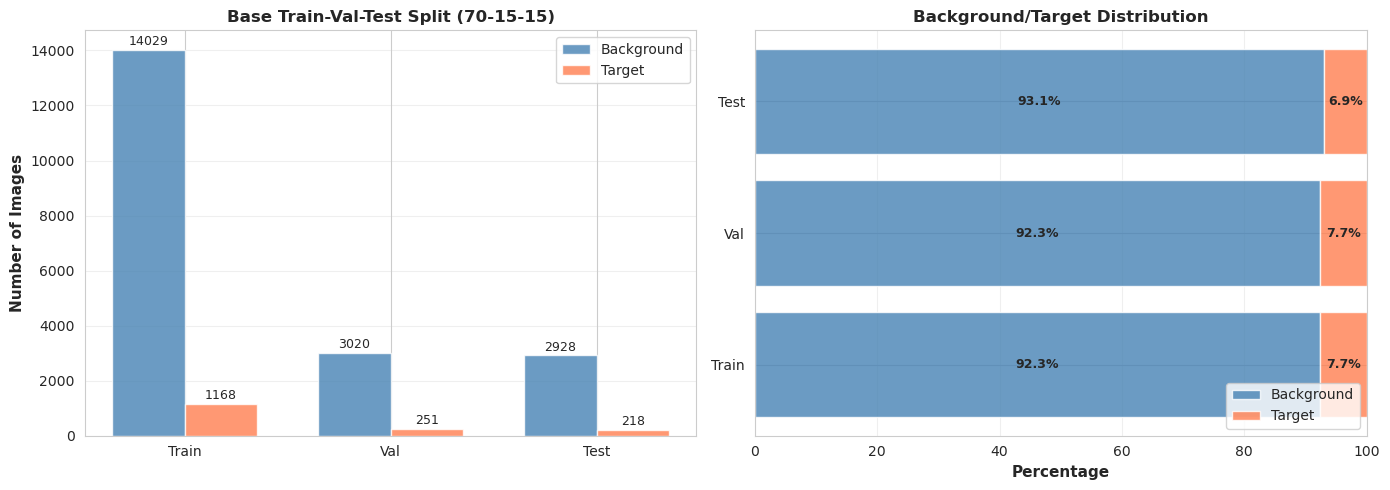

In [48]:
# Visualization 1: Base train-val-test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Image counts for base split
sets = ['Train', 'Val', 'Test']
bg_counts = [
    tvt_split['train']['num_bg'],
    tvt_split['val']['num_bg'],
    tvt_split['test']['num_bg']
]
tg_counts = [
    tvt_split['train']['num_tg'],
    tvt_split['val']['num_tg'],
    tvt_split['test']['num_tg']
]

x = np.arange(len(sets))
width = 0.35

ax = axes[0]
ax.bar(x - width/2, bg_counts, width, label='Background', color='steelblue', alpha=0.8)
ax.bar(x + width/2, tg_counts, width, label='Target', color='coral', alpha=0.8)
ax.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax.set_title('Base Train-Val-Test Split (70-15-15)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sets)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bg, tg) in enumerate(zip(bg_counts, tg_counts)):
    ax.text(i - width/2, bg + 50, str(bg), ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, tg + 50, str(tg), ha='center', va='bottom', fontsize=9)

# Plot 2: Proportions
ax = axes[1]
labels = sets
bg_ratios = [
    tvt_split['train']['num_bg'] / tvt_split['train']['total'] * 100,
    tvt_split['val']['num_bg'] / tvt_split['val']['total'] * 100,
    tvt_split['test']['num_bg'] / tvt_split['test']['total'] * 100
]
tg_ratios = [
    tvt_split['train']['num_tg'] / tvt_split['train']['total'] * 100,
    tvt_split['val']['num_tg'] / tvt_split['val']['total'] * 100,
    tvt_split['test']['num_tg'] / tvt_split['test']['total'] * 100
]

for i, label in enumerate(labels):
    ax.barh(i, bg_ratios[i], label='Background' if i==0 else '', color='steelblue', alpha=0.8)
    ax.barh(i, tg_ratios[i], left=bg_ratios[i], label='Target' if i==0 else '', color='coral', alpha=0.8)
    ax.text(bg_ratios[i]/2, i, f'{bg_ratios[i]:.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)
    ax.text(bg_ratios[i] + tg_ratios[i]/2, i, f'{tg_ratios[i]:.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage', fontsize=11, fontweight='bold')
ax.set_title('Background/Target Distribution', fontsize=12, fontweight='bold')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlim(0, 100)
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(SPLITS_OUTPUT_DIR / 'tvt_base_split.png', dpi=150, bbox_inches='tight')
print('✓ Saved: tvt_base_split.png')
plt.show()


✓ Saved: tvt_ratio_progression.png


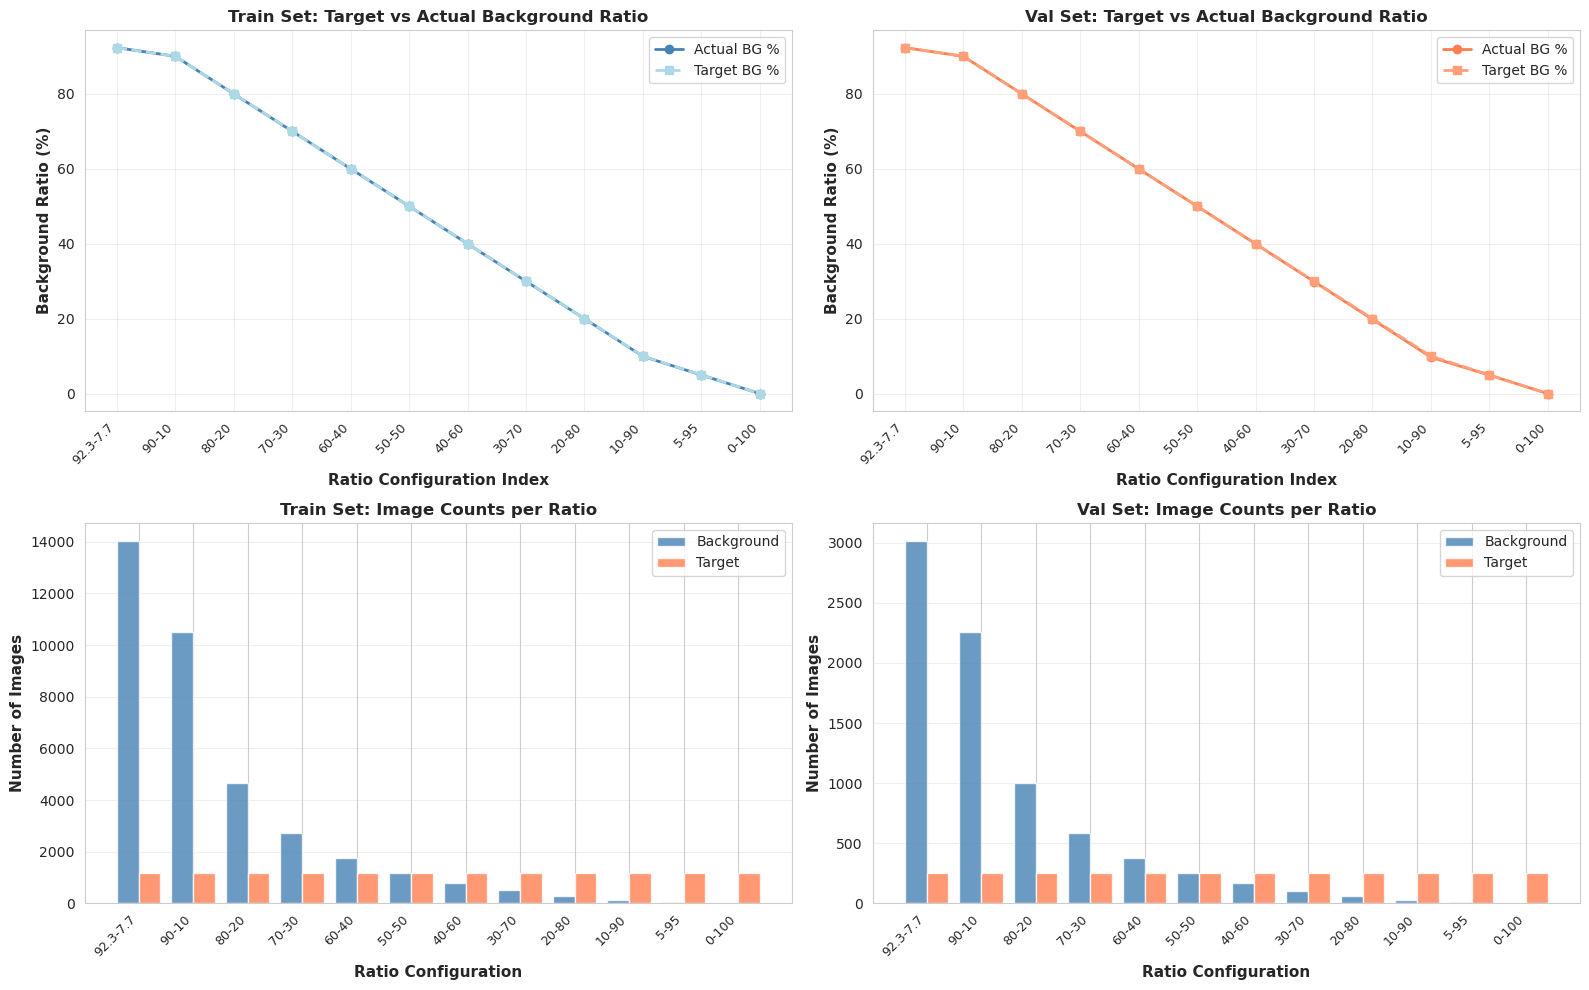

In [49]:
# Visualization 2: Train and Val ratio progression
train_stats = tvt_stats_df[tvt_stats_df['set'] == 'train'].copy()
val_stats = tvt_stats_df[tvt_stats_df['set'] == 'val'].copy()

# Sort by target_bg to show progression
train_stats = train_stats.sort_values('target_bg', ascending=False).reset_index(drop=True)
val_stats = val_stats.sort_values('target_bg', ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Train set background ratio progression
ax = axes[0, 0]
x = np.arange(len(train_stats))
ax.plot(x, train_stats['actual_bg'], marker='o', linewidth=2, markersize=6, label='Actual BG %', color='steelblue')
ax.plot(x, train_stats['target_bg'], marker='s', linewidth=2, markersize=6, label='Target BG %', color='lightblue', linestyle='--')
ax.set_xlabel('Ratio Configuration Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Background Ratio (%)', fontsize=11, fontweight='bold')
ax.set_title('Train Set: Target vs Actual Background Ratio', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(train_stats['ratio'].values, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Val set background ratio progression
ax = axes[0, 1]
ax.plot(x, val_stats['actual_bg'], marker='o', linewidth=2, markersize=6, label='Actual BG %', color='coral')
ax.plot(x, val_stats['target_bg'], marker='s', linewidth=2, markersize=6, label='Target BG %', color='lightsalmon', linestyle='--')
ax.set_xlabel('Ratio Configuration Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Background Ratio (%)', fontsize=11, fontweight='bold')
ax.set_title('Val Set: Target vs Actual Background Ratio', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(val_stats['ratio'].values, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Train set image counts
ax = axes[1, 0]
x = np.arange(len(train_stats))
ax.bar(x - 0.2, train_stats['num_bg'], width=0.4, label='Background', color='steelblue', alpha=0.8)
ax.bar(x + 0.2, train_stats['num_tg'], width=0.4, label='Target', color='coral', alpha=0.8)
ax.set_xlabel('Ratio Configuration', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax.set_title('Train Set: Image Counts per Ratio', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(train_stats['ratio'].values, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Val set image counts
ax = axes[1, 1]
ax.bar(x - 0.2, val_stats['num_bg'], width=0.4, label='Background', color='steelblue', alpha=0.8)
ax.bar(x + 0.2, val_stats['num_tg'], width=0.4, label='Target', color='coral', alpha=0.8)
ax.set_xlabel('Ratio Configuration', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=11, fontweight='bold')
ax.set_title('Val Set: Image Counts per Ratio', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(val_stats['ratio'].values, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(SPLITS_OUTPUT_DIR / 'tvt_ratio_progression.png', dpi=150, bbox_inches='tight')
print('✓ Saved: tvt_ratio_progression.png')
plt.show()


✓ Saved: tvt_selected_ratios_comparison.png


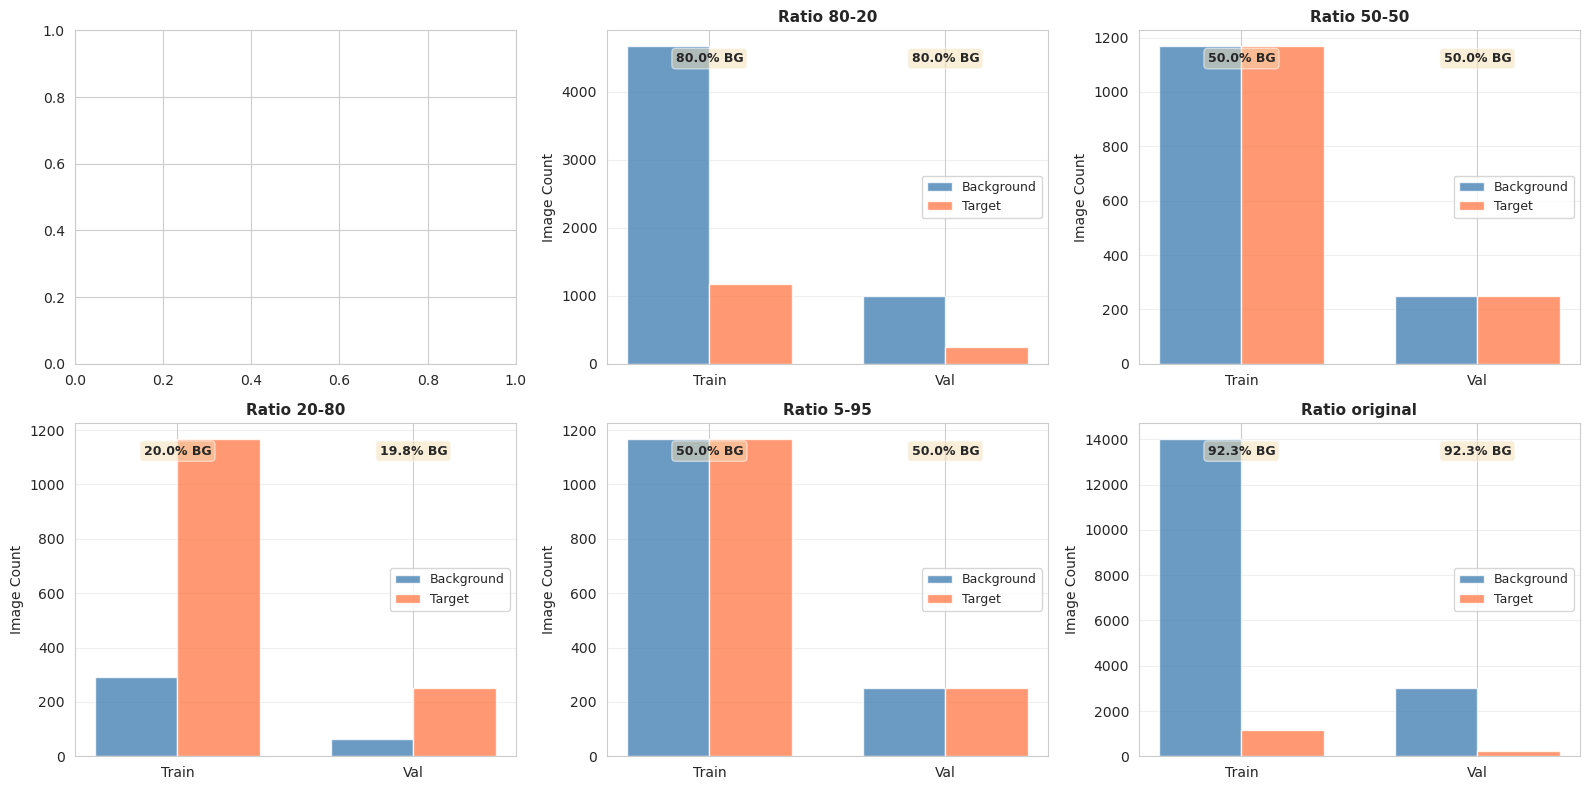

In [50]:
# Visualization 3: Train-Val comparison for selected ratios
selected_ratios = ['95', '80', '50', '20', '5', 'original']
ratio_labels = ['95-5', '80-20', '50-50', '20-80', '5-95', 'original']

# Map to actual ratio keys
ratio_mapping = {
    '95': '95-5',
    '80': '80-20', 
    '50': '50-50',
    '20': '20-80',
    '5': '5-95',
    'original': f'{train_bg_ratio:.0f}-{train_tg_ratio:.0f}'
}

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, (key, label) in enumerate(zip(selected_ratios, ratio_labels)):
    ax = axes[idx]
    
    # Find corresponding stats
    train_row = train_stats[train_stats['ratio'].str.startswith(key)] if key != 'original' else train_stats[train_stats['ratio'].str.contains(f'{train_bg_ratio:.0f}')]
    val_row = val_stats[val_stats['ratio'].str.startswith(key)] if key != 'original' else val_stats[val_stats['ratio'].str.contains(f'{train_bg_ratio:.0f}')]
    
    if len(train_row) > 0 and len(val_row) > 0:
        train_data = train_row.iloc[0]
        val_data = val_row.iloc[0]
        
        sets = ['Train', 'Val']
        bg_counts = [train_data['num_bg'], val_data['num_bg']]
        tg_counts = [train_data['num_tg'], val_data['num_tg']]
        
        x = np.arange(len(sets))
        width = 0.35
        
        ax.bar(x - width/2, bg_counts, width, label='Background', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, tg_counts, width, label='Target', color='coral', alpha=0.8)
        
        ax.set_title(f'Ratio {label}', fontsize=11, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(sets)
        ax.set_ylabel('Image Count', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(fontsize=9)
        
        # Add proportion info
        train_bg_pct = train_data['actual_bg']
        val_bg_pct = val_data['actual_bg']
        ax.text(0, max(bg_counts + tg_counts) * 0.95, f'{train_bg_pct:.1f}% BG', 
                ha='center', fontsize=9, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.text(1, max(bg_counts + tg_counts) * 0.95, f'{val_bg_pct:.1f}% BG', 
                ha='center', fontsize=9, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(SPLITS_OUTPUT_DIR / 'tvt_selected_ratios_comparison.png', dpi=150, bbox_inches='tight')
print('✓ Saved: tvt_selected_ratios_comparison.png')
plt.show()


## Upsampling Target Frames (50-50 Class-Balanced)

In [52]:
import random

def create_upsampled_50_50_splits(tvt_split, image_class_info, seed=42):
    """
    Create 50-50 balanced splits from the original split by upsampling target frames,
    ensuring per-class balance.
    
    Strategy:
    1. For each split (train/val), identify all background and target images
    2. For each target image, get its primary class
    3. Group target images by class
    4. Calculate upsample ratio needed to achieve 50-50 balance
    5. Upsample each class proportionally to maintain class balance
    
    Args:
        tvt_split: Dictionary with train/val/test splits from create_train_val_test_split()
        image_class_info: Dictionary mapping image paths to class information
        seed: Random seed for reproducibility
        
    Returns:
        Dictionary with 'train', 'val', 'test' keys containing upsampled 50-50 balanced splits
    """
    np.random.seed(seed)
    random.seed(seed)
    
    def get_image_primary_class(img_path):
        """Get the primary class (most frequent) for an image"""
        if img_path not in image_class_info:
            return None
        classes = image_class_info[img_path].get('classes', [])
        if classes:
            return max(set(classes), key=classes.count)
        return None
    
    def upsample_split_50_50(split_data):
        """
        Upsample a single split to achieve 50-50 balance while maintaining per-class balance.
        """
        bg_images = [img for img in split_data['images'] if img in bg_original or 
                     image_class_info.get(img, {}).get('num_targets', 0) == 0]
        tg_images = [img for img in split_data['images'] if img not in bg_original and 
                     image_class_info.get(img, {}).get('num_targets', 0) > 0]
        
        if not tg_images:
            return split_data['images']
        
        # Group target images by class
        tg_by_class = defaultdict(list)
        for img in tg_images:
            primary_class = get_image_primary_class(img)
            if primary_class:
                tg_by_class[primary_class].append(img)
        
        # Calculate upsampling factors
        num_bg = len(bg_images)
        num_tg = len(tg_images)
        
        # To achieve 50-50, we need: num_bg == num_upsampled_tg
        total_needed = num_bg * 2  # 50% BG, 50% TG
        target_per_class = (total_needed // 2) / len(tg_by_class)  # Distribute equally among classes
        
        print(f'\n  Original: {num_bg} BG, {num_tg} TG')
        print(f'  Target for 50-50: {num_bg} BG, {num_bg} TG')
        print(f'  Classes in targets: {list(tg_by_class.keys())}')
        
        # Upsample each class to maintain balance
        upsampled_tg = []
        for cls, images in sorted(tg_by_class.items()):
            num_to_sample = int(np.round(target_per_class))
            # Sample with replacement if needed, without replacement if possible
            if num_to_sample > len(images):
                sampled = np.random.choice(images, size=num_to_sample, replace=True).tolist()
            else:
                sampled = np.random.choice(images, size=num_to_sample, replace=False).tolist()
            upsampled_tg.extend(sampled)
            cls_name = CLASS_ID_TO_NAME.get(cls, cls)
            print(f'    {cls_name:12s} ({cls}): {len(images):4d} -> {len(sampled):4d} (upsample {len(sampled)/len(images):.2f}x)')
        
        # Combine and shuffle
        upsampled_images = bg_images + upsampled_tg
        random.shuffle(upsampled_images)
        
        final_bg = len(bg_images)
        final_tg = len(upsampled_tg)
        print(f'  Final: {final_bg} BG ({final_bg/(final_bg+final_tg)*100:.1f}%), ' + 
              f'{final_tg} TG ({final_tg/(final_bg+final_tg)*100:.1f}%)')
        
        return upsampled_images
    
    upsampled_splits = {}
    
    # Process train split
    print('='*100)
    print('TRAIN SPLIT - Upsampling to 50-50 with per-class balance')
    print('='*100)
    upsampled_splits['train'] = {
        'images': upsample_split_50_50(tvt_split['train']),
        'videos': tvt_split['train']['videos'],
        'num_bg': None,  # Will be calculated
        'num_tg': None,
        'total': None
    }
    
    # Process val split
    print('\n' + '='*100)
    print('VAL SPLIT - Upsampling to 50-50 with per-class balance')
    print('='*100)
    upsampled_splits['val'] = {
        'images': upsample_split_50_50(tvt_split['val']),
        'videos': tvt_split['val']['videos'],
        'num_bg': None,
        'num_tg': None,
        'total': None
    }
    
    # Keep test split unchanged
    upsampled_splits['test'] = tvt_split['test']
    
    # Calculate final statistics
    for split_name in ['train', 'val']:
        images = upsampled_splits[split_name]['images']
        num_bg = len([img for img in images if img in bg_original])
        num_tg = len(images) - num_bg
        upsampled_splits[split_name]['num_bg'] = num_bg
        upsampled_splits[split_name]['num_tg'] = num_tg
        upsampled_splits[split_name]['total'] = len(images)
    
    return upsampled_splits

In [ ]:
# Execute upsampling to create 50-50 balanced splits
upsampled_splits = create_upsampled_50_50_splits(tvt_split, image_class_info, seed=RANDOM_SEED)

print('\n' + '='*100)
print('UPSAMPLED SPLITS SUMMARY')
print('='*100)
for split_name in ['train', 'val', 'test']:
    split_data = upsampled_splits[split_name]
    print(f'\n{split_name.upper()}:')
    print(f'  Total images: {split_data["total"]}')
    print(f'  Background:  {split_data["num_bg"]} ({split_data["num_bg"]/split_data["total"]*100:.1f}%)')
    print(f'  Target:      {split_data["num_tg"]} ({split_data["num_tg"]/split_data["total"]*100:.1f}%)')
    print(f'  Videos:      {len(split_data["videos"])}')

TRAIN SPLIT - Upsampling to 50-50 with per-class balance

  Original: 14029 BG, 1168 TG
  Target for 50-50: 14029 BG, 14029 TG
  Classes in targets: ['Unknown', 'Bird', 'Plane', 'Insect', 'Other', 'Bat']
    Bat          (Bat):   46 -> 2338 (upsample 50.83x)
    Bird         (Bird):  326 -> 2338 (upsample 7.17x)
    Insect       (Insect):   36 -> 2338 (upsample 64.94x)
    Other        (Other):   10 -> 2338 (upsample 233.80x)
    Plane        (Plane):  241 -> 2338 (upsample 9.70x)
    Unknown      (Unknown):  509 -> 2338 (upsample 4.59x)
  Final: 14029 BG (50.0%), 14028 TG (50.0%)

VAL SPLIT - Upsampling to 50-50 with per-class balance

  Original: 3020 BG, 251 TG
  Target for 50-50: 3020 BG, 3020 TG
  Classes in targets: ['Unknown', 'Insect', 'Bird', 'Plane', 'Other']
    Bird         (Bird):   56 ->  604 (upsample 10.79x)
    Insect       (Insect):   16 ->  604 (upsample 37.75x)
    Other        (Other):    5 ->  604 (upsample 120.80x)
    Plane        (Plane):   58 ->  604 (upsample

In [54]:
# Save txts files
for split_name, split_data in upsampled_splits.items():
    output_dir = SPLITS_OUTPUT_DIR / 'upsampled_50_50' / split_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    txt_file = output_dir / f'{split_name}_upsampled_50_50.txt'
    with open(txt_file, 'w') as f:
        for img_path in split_data['images']:
            f.write(f'{img_path}\n')